In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')

    FOLDERNAME = "Work/Assignment1"

    work_dir = f'/content/drive/My Drive/{FOLDERNAME}'
except ImportError:
    work_dir = './'

import sys
sys.path.append(work_dir)

import os
data_dir = os.path.join(work_dir, 'data')

Mounted at /content/drive


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the Instructions.docx.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
# Run some setup code for this notebook.

import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
   """
   Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
   it for the linear classifier. These are the same steps as we used for the
   SVM, but condensed to a single function.
   """

   # Download and construct the CIFAR-10 dataset.
   train_dataset = torchvision.datasets.CIFAR10(root=data_dir,
                                                train=True,
                                                transform=transforms.ToTensor(),
                                                download=True)

   test_dataset = torchvision.datasets.CIFAR10(root=data_dir,
                                                train=False,
                                                transform=transforms.ToTensor(),
                                                download=True)

   print(f'CIFAR-10 training dataset has {len(train_dataset)} images, and test dataset has {len(test_dataset)} images.')

   X_train = torch.stack([x for x, _ in train_dataset]) # (num_train, c, h, w)
   y_train = torch.tensor(train_dataset.targets) # (num_train,)
   X_test = torch.stack([x for x, _ in test_dataset]) # (num_test, c, h, w)
   y_test = torch.tensor(test_dataset.targets) # (num_test,)

   # To accelerate, put data to a CUDA GPU device if you have, e.g. the T4 GPU on Google Colab.
   device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
   X_train = X_train.to(device)
   y_train = y_train.to(device)
   X_test = X_test.to(device)
   y_test = y_test.to(device)

   # Subsample the data
   mask = range(num_training, num_training + num_validation)
   X_val = X_train[mask]
   y_val = y_train[mask]

   # Our training set will be the first num_train points from the original
   # training set.
   mask = range(num_training)
   X_train = X_train[mask]
   y_train = y_train[mask]

   # We will also make a development set, which is a small subset of
   # the training set.
   mask = np.random.choice(num_training, num_dev, replace=False)
   X_dev = X_train[mask]
   y_dev = y_train[mask]

   # We use the first num_test points of the original test set as our
   # test set.
   mask = range(num_test)
   X_test = X_test[mask]
   y_test = y_test[mask]

   # Preprocessing: reshape the image data into rows
   X_train = torch.reshape(X_train, (X_train.shape[0], -1))
   X_val = torch.reshape(X_val, (X_val.shape[0], -1))
   X_test = torch.reshape(X_test, (X_test.shape[0], -1))
   X_dev = torch.reshape(X_dev, (X_dev.shape[0], -1))

   # Normalize the data: subtract the mean image
   mean_image = torch.mean(X_train, axis=0)
   X_train -= mean_image
   X_val -= mean_image
   X_test -= mean_image
   X_dev -= mean_image

   # Add bias dimension and transform into columns
   X_train = torch.hstack([X_train, torch.ones((X_train.shape[0], 1), device=device)])
   X_val = torch.hstack([X_val, torch.ones((X_val.shape[0], 1), device=device)])
   X_test = torch.hstack([X_test, torch.ones((X_test.shape[0], 1), device=device)])
   X_dev = torch.hstack([X_dev, torch.ones((X_dev.shape[0], 1), device=device)])

   return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 training dataset has 50000 images, and test dataset has 10000 images.
Train data shape:  torch.Size([49000, 3073])
Train labels shape:  torch.Size([49000])
Validation data shape:  torch.Size([1000, 3073])
Validation labels shape:  torch.Size([1000])
Test data shape:  torch.Size([1000, 3073])
Test labels shape:  torch.Size([1000])
dev data shape:  torch.Size([500, 3073])
dev labels shape:  torch.Size([500])


## Softmax Classifier

Your code for this section will all be written inside `src/classifiers/softmax.py`.


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file src/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from src.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = torch.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.302733
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in*



In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from src.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.011921 analytic: 0.002345, relative error: 6.712940e-01
numerical: 0.011921 analytic: 0.011103, relative error: 3.552833e-02
numerical: -0.011921 analytic: -0.007202, relative error: 2.467667e-01
numerical: 0.023842 analytic: 0.004503, relative error: 6.822520e-01
numerical: 0.011921 analytic: 0.005092, relative error: 4.013965e-01
numerical: -0.023842 analytic: -0.022021, relative error: 3.969841e-02
numerical: 0.011921 analytic: 0.010413, relative error: 6.752932e-02
numerical: 0.011921 analytic: 0.009582, relative error: 1.087727e-01
numerical: 0.000000 analytic: 0.002398, relative error: 1.000000e+00
numerical: 0.000000 analytic: 0.005157, relative error: 1.000000e+00
numerical: 0.011921 analytic: 0.010406, relative error: 6.785185e-02
numerical: 0.023842 analytic: 0.015902, relative error: 1.997721e-01
numerical: -0.011921 analytic: -0.001439, relative error: 7.846419e-01
numerical: 0.000000 analytic: 0.006362, relative error: 1.000000e+00
numerical: 0.023842 analytic

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from src.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = torch.norm(grad_naive - grad_vectorized, p='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.302733e+00 computed in 0.289084s
vectorized loss: 2.302733e+00 computed in 0.026444s
Loss difference: 0.000000
Gradient difference: 0.000000


In [13]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from src.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7, 0.07]
regularization_strengths = [2.5e4, 5e4, 0.001]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for lr in learning_rates:
    for reg in regularization_strengths:
        softmax_model = Softmax()
        loss_hist = softmax_model.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1000, batch_size=10)

        # Evaluate on the training set
        y_train_pred = softmax_model.predict(X_train)
        train_accuracy = (y_train_pred == y_train).float().mean().item()

        # Evaluate on the validation set
        y_val_pred = softmax_model.predict(X_val)
        val_accuracy = (y_val_pred == y_val).float().mean().item()

        # Store the results
        results[(lr, reg)] = (train_accuracy, val_accuracy)

        # Keep track of the best validation accuracy and model
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax_model
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 1.000000e-03 train accuracy: 0.079429 val accuracy: 0.076000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.165959 val accuracy: 0.188000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.235959 val accuracy: 0.229000
lr 5.000000e-07 reg 1.000000e-03 train accuracy: 0.135959 val accuracy: 0.147000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.221776 val accuracy: 0.235000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.213612 val accuracy: 0.221000
lr 7.000000e-02 reg 1.000000e-03 train accuracy: 0.339347 val accuracy: 0.353000
lr 7.000000e-02 reg 2.500000e+04 train accuracy: 0.100265 val accuracy: 0.087000
lr 7.000000e-02 reg 5.000000e+04 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.353000


In [14]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = torch.mean((y_test == y_test_pred).float())
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.332000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ True


$\color{blue}{\textit Your Explanation:}$ For the SVM hinge loss, correctly classified examples with margin greater than 1 contribute zero loss, so adding one doesn't change the overall loss. In contrast, the softmax loss always gives a positive contribution, even for correctly classified examples.



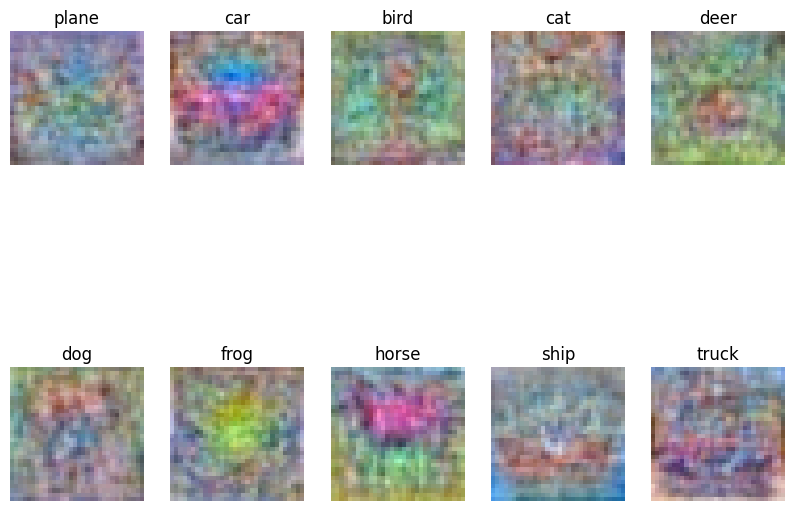

In [15]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.cpu().numpy()  # Put it back to CPU for visualization if you have put it to GPU
w = w.reshape(3, 32, 32, 10).transpose(1, 2, 0, 3)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])